In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array,load_img,to_categorical
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

x_train=x_train[::100]
y_train=y_train[::100]
x_test=x_test[::100]
y_test=y_test[::100]

print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of x_test: ",x_test.shape)
print("Shape of y_test: ",y_test.shape)


Shape of x_train:  (500, 32, 32, 3)
Shape of y_train:  (500, 1)
Shape of x_test:  (100, 32, 32, 3)
Shape of y_test:  (100, 1)


In [3]:
y_train[:5]

array([[6],
       [8],
       [6],
       [2],
       [2]], dtype=uint8)

In [4]:
numberOfClass=len(np. unique(y_train))

y_train=to_categorical(y_train,numberOfClass)
y_test=to_categorical(y_test,numberOfClass)

y_train[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [5]:
input_shape=x_train.shape[1:]

input_shape

(32, 32, 3)

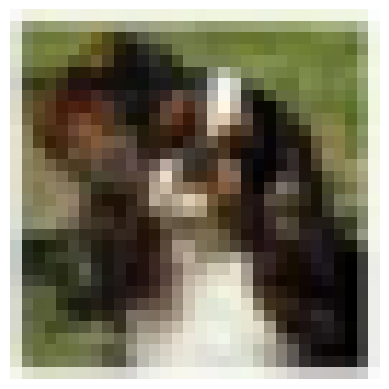

In [6]:
plt.imshow(x_train[5].astype(np.uint8))
plt.axis("off")
plt.show()



In [7]:
#vgg19 모형에 맞게 48x48로 resize
import cv2
def resize_img(img):
    numberOfImage=img.shape[0]
    new_array=np.zeros((numberOfImage,48,48,3))
    for i in range(numberOfImage):
        new_array[i]=cv2.resize(img[i,:,:,:],(48,48))
    return new_array
    
x_train=resize_img(x_train)
x_test=resize_img(x_test)
print(x_train.shape, x_test.shape)


(500, 48, 48, 3) (100, 48, 48, 3)


In [8]:
vgg=VGG19(include_top=False,weights="imagenet",input_shape=(48,48,3))
vgg.summary()



Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [9]:
for layer in vgg.layers:
    layer.trainable=False

In [10]:
layer=[
       layers.Flatten(),
       layers.Dense(128),
       layers.Dense(numberOfClass,activation="softmax"),
       ]
model=tf.keras.Sequential(vgg.layers+layer)    # 기존모델에 layer 추가
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 12, 12, 256)       2

In [11]:
model.compile(loss="categorical_crossentropy",
             optimizer="rmsprop",
             metrics=["accuracy"])



In [12]:
import gc
tf.keras.backend.clear_session()
gc.collect()


2856

In [13]:
hist=model.fit(x_train,y_train,validation_split=0.3,
               epochs=5,batch_size=1)


Epoch 1/5
350/350 [==============================] - 14s 20ms/step - loss: 21.2148 - accuracy: 0.2714 - val_loss: 19.0021 - val_accuracy: 0.3533
Epoch 2/5
350/350 [==============================] - 7s 19ms/step - loss: 8.6417 - accuracy: 0.5571 - val_loss: 21.8627 - val_accuracy: 0.3067
Epoch 3/5
350/350 [==============================] - 7s 19ms/step - loss: 5.1382 - accuracy: 0.6686 - val_loss: 20.6125 - val_accuracy: 0.3933
Epoch 4/5
350/350 [==============================] - 7s 19ms/step - loss: 4.1266 - accuracy: 0.7714 - val_loss: 21.0649 - val_accuracy: 0.3600
Epoch 5/5
350/350 [==============================] - 7s 19ms/step - loss: 2.4583 - accuracy: 0.8086 - val_loss: 24.9521 - val_accuracy: 0.3600


In [14]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


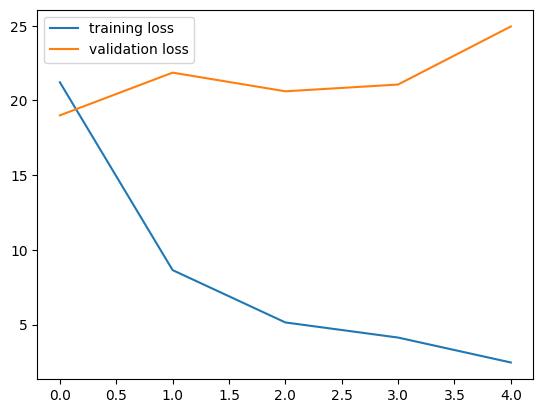

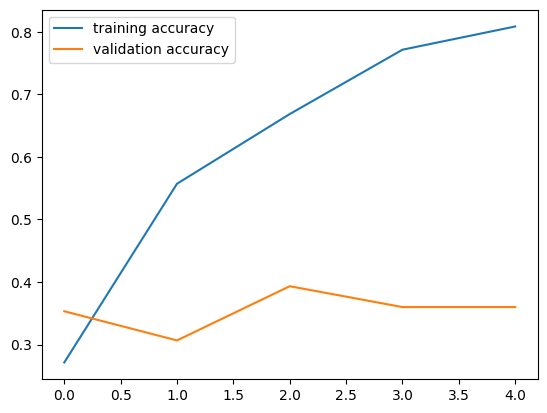

In [15]:
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="validation loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(hist.history["accuracy"],label="training accuracy")
plt.plot(hist.history["val_accuracy"],label="validation accuracy")
plt.legend()
plt.show()



In [16]:
model.evaluate(x_test,y_test)

4/4 [==============================] - 1s 138ms/step - loss: 21.1498 - accuracy: 0.3100


[21.1497802734375, 0.3100000023841858]